### Sentiment Classification Sentiment Neuron XGBoost
This notebook uses the unsupervised text encoder from [this project](https://github.com/openai/generating-reviews-discovering-sentiment) as a feature extraction technique, and compares the performance of sentiment classifiers based on the sentiment neuron alone, and alternatively, a variety of classifiers trained on the full feature embeddings.

In [99]:
from src.encoder import Model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr

In [2]:
model = Model()




Instructions for updating:
dim is deprecated, use axis instead




In [3]:
df = pd.read_csv('res/tweets.csv')

In [77]:
sample = df.groupby('airline_sentiment').sample(300)
corpus = sample.text.values.tolist()

In [78]:
X = model.transform(corpus)

166.085 seconds to transform 900 examples


In [79]:
X.shape

(900, 4096)

In [80]:
y = sample.airline_sentiment.values.tolist()

In [81]:
def binarize_label(label):
    if 'negative' in label:
        return 0
    elif 'neutral' in label:
        return 1
    else:
        return 2
    
y = [binarize_label(label) for label in y]

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
# using full-featured embeddings

In [87]:
clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', gamma='auto'))

In [88]:
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [89]:
clf.score(X_test, y_test)

0.6933333333333334

In [90]:
xgbc = XGBClassifier()
params = {
    'verbosity': 0,
    'n_estimators': 1000
}
xgbc.set_params(**params)
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

In [91]:
preds = xgbc.predict(X_test)

In [92]:
accuracy_score(y_test, preds)

0.7955555555555556

In [ ]:
### using sentiment neuron only

In [93]:
sentiment_unit_train = X_train[:, 2388].reshape(-1, 1)
sentiment_unit_test = X_test[:, 2388].reshape(-1, 1)

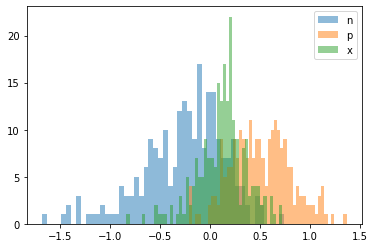

In [94]:
plt.hist(sentiment_unit_train[np.array(y_train)==0].flatten(), bins=50, alpha=0.5, label='n')
plt.hist(sentiment_unit_train[np.array(y_train)==2].flatten(), bins=50, alpha=0.5, label='p')
plt.hist(sentiment_unit_train[np.array(y_train)==1].flatten(), bins=50, alpha=0.5, label='x')
plt.legend()
plt.show()

In [95]:
clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', gamma='auto'))
clf.fit(sentiment_unit_train, y_train)
clf.score(sentiment_unit_test, y_test)

0.6755555555555556

In [96]:
spearmanr(sentiment_unit_train, y_train)

SpearmanrResult(correlation=0.724398458883785, pvalue=8.138540526559736e-111)

In [97]:
xgbc = XGBClassifier()
params = {
    'verbosity': 0,
    'n_estimators': 1000,
    'subsample': 0.5,
    'seed': 0,
    'max_depth': 6,
    'gamma': 0,
    'eta': 0.01
}
xgbc.set_params(**params)
xgbc.fit(sentiment_unit_train, y_train)

C:\Users\Christian\Anaconda3\envs\deepsight\lib\site-packages\xgboost\data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.01, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.00999999978, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=0, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=0)

In [98]:
preds = xgbc.predict(sentiment_unit_test)
accuracy_score(y_test, preds)

0.6133333333333333

### NOTE
With only a single feature, XGBoost now performs worse than the Support Vector Classifier, which makes sense given that the XGBoost algorithm is optimized for high-dimensional data.

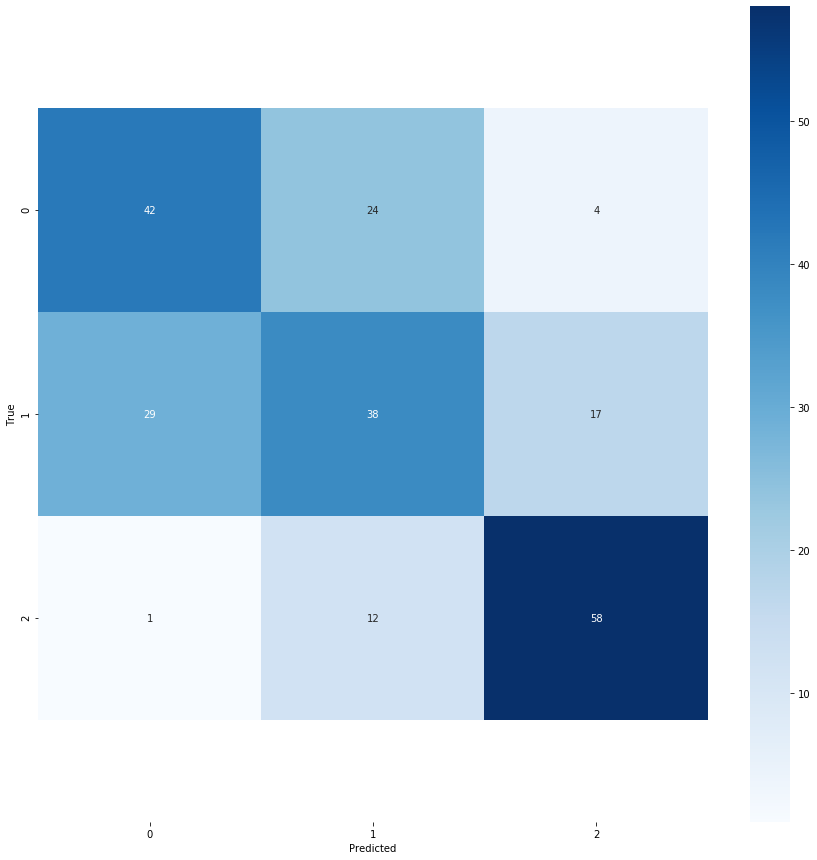

In [100]:
# Create the confusion matrix and heatmap.
cm = confusion_matrix(y_test, preds)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues")
# Adjust y_axis to resolve matplotlib 3.1.1 bug.
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
# Set axis labels.
ax.set_xlabel('Predicted')
ax.set_ylabel('True');
plt.show()

### NOTE
It is notable how well the models still perform with only a single feature (compared to over 4000 features with the full embeddings) if this feature is highly-attuned to the signal we wish to identify. This clearly demonstrates the importance of well-designed features.